# Inversion of individual Hanle profiles


### Here we will invert a couple of profiles that exhibit Hanle effect signatures. These are kindly provided by David Orozco Suarez. We will also look ast some of the maps observed by the same telescope later. 

In [1]:
import numpy as np 
import hazel 
import matplotlib.pyplot as plt 
import h5py
from astropy.io import fits 

In [2]:
# Let's first load a profile:
data = np.loadtxt("profiles/profA1.perf",skiprows=1,unpack=True)
data.shape

(9, 81)

In [3]:
ll = np.copy(data[0]) + 10829.09
stokes = np.copy(data[1:5])
noise = np.copy(data[5:])

In [ ]:
# Let's visualize these profiles: 
plt.figure(figsize=[14,8])
plt.subplot(221)
plt.plot(ll,stokes[0,:],'o')
plt.ylabel("Stokes I")
plt.subplot(222)
plt.plot(ll,stokes[1,:],'o')
plt.ylabel("Stokes Q")
plt.subplot(223)
plt.plot(ll,stokes[2,:],'o')
plt.ylabel("Stokes U")
plt.xlabel("Wavelength")
plt.subplot(224)
plt.plot(ll,stokes[3,:],'o')
plt.ylabel("Stokes V")
plt.xlabel("Wavelength")

### We will go straight to the inversion, we know what we need to do! 

In [4]:
# First the wavelength axis
n_wvl = len(ll)
np.savetxt('10830_A1.wavelength', ll, header='lambda')

# Then we will save something called, 'weigths', this will allow us to fine-tune the inversion if needed.
f = open('10830_A1.weights', 'w')
f.write('# WeightI WeightQ WeightU WeightV\n')
for i in range(n_wvl):
    f.write('1.0    1.0   1.0   1.0\n')
f.close()

# And finally, the 'observed' Stokes parameters:

# Note, the magical number we are multiplying stokes vector with will become clear soon!
stokes_to_fit = stokes * 0.89388

f = open('10830_A1_stokes.1d', 'wb')
f.write(b'# LOS theta_LOS, phi_LOS, gamma_LOS\n')
f.write(b'50.0 0.0 0.0\n') # This should be identical to the above otherwise we will get inconsistent results. 
                            # this is something you should know from the observations
f.write(b'\n')
f.write(b'# Boundary condition I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)\n')
f.write(b'1.0 0.0 0.0 0.0\n')
f.write(b'\n')
f.write(b'# SI SQ SU SV sigmaI sigmaQ sigmaU sigmaV\n')
tmp = np.vstack([stokes_to_fit, noise]) # the second one only adds appropriate noise next to each Stokes
                                                        # measurement
np.savetxt(f, tmp.T)
f.close()



In [31]:
nrand = 20
iterator = hazel.Iterator(use_mpi=False)
mod = hazel.Model('conf_test_A1.ini', working_mode='inversion', verbose=1, rank=iterator.get_rank(), randomization=nrand)
iterator.use_model(model=mod)
iterator.run_all_pixels()

2022-02-03 15:55:18,859 - Hazel2 v1.0
2022-02-03 15:55:18,860 - Using configuration from file : conf_test_A1.ini
2022-02-03 15:55:18,862 - Backtracking mode : brent
2022-02-03 15:55:18,862 - Adding spectral region spec1
2022-02-03 15:55:18,862 -   - Reading wavelength axis from 10830_A1.wavelength
2022-02-03 15:55:18,863 -   - Reading wavelength weights from 10830_A1.weights
2022-02-03 15:55:18,865 -   - Using observations from 10830_A1_stokes.1d
2022-02-03 15:55:18,865 -   - No mask for pixels
2022-02-03 15:55:18,865 -   - No instrumental profile
2022-02-03 15:55:18,865 -   - Using LOS ['50.0', '0.0', '0.0']
2022-02-03 15:55:18,866 -   - Using boundary condition ['1.0', '0.0', '0.0', '0.0']
2022-02-03 15:55:18,866 - Using 3 cycles
2022-02-03 15:55:18,866 - Using analytical RFs if possible : False
2022-02-03 15:55:18,867 - Using 10 max. iterations
2022-02-03 15:55:18,867 - Using a maximum of 20 randomizations
2022-02-03 15:55:18,867 - Stopping when relative error is below 1e-05
2022-02

In [25]:
nrand = 2
result = h5py.File('output_onepixel.h5','r')
fit = np.copy(result['spec1']['stokes'])
fit = fit.reshape(nrand,4,n_wvl)
fit.shape

(2, 4, 81)

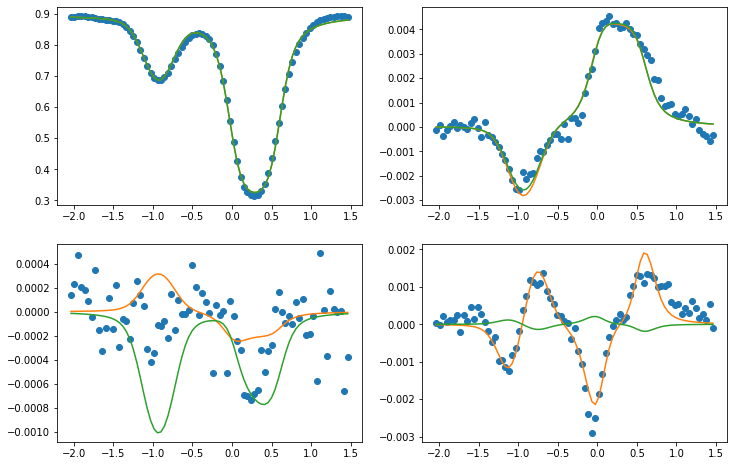

In [26]:
n_rand = 2
plt.figure(figsize=[12,8])
plt.subplot(221)
plt.plot(ll-10830,stokes_to_fit[0,:],'o')
for i in range(0,n_rand):
    plt.plot(ll-10830,fit[i,0,:])
plt.subplot(222)
plt.plot(ll-10830,stokes_to_fit[1,:],'o')
for i in range(0,n_rand):
    plt.plot(ll-10830,fit[i,1,:])

plt.subplot(223)
plt.plot(ll-10830,stokes_to_fit[2,:],'o')
for i in range(0,n_rand):
    plt.plot(ll-10830,fit[i,2,:])

plt.subplot(224)
plt.plot(ll-10830,stokes_to_fit[3,:],'o')
for i in range(0,n_rand):
    plt.plot(ll-10830,fit[i,3,:])


In [27]:
print(result['spec1']['chi2'][0])

[[87.90955898 87.90955898 87.90955898]
 [97.01571947 97.01571947 97.01571947]]


In [28]:
good = [0]


In [29]:
result['ch1'].keys()
# Print them neatly:
for i in good:
    print ("----------------------------------")
    print ("Fit # ",i)
    print ("----------------------------------")
    print ("Bx= ",result['ch1']['Bx'][0,i,0])
    print ("By= ",result['ch1']['By'][0,i,0])
    print ("Bz= ",result['ch1']['Bz'][0,i,0])
    print ("tau= ",result['ch1']['tau'][0,i,0])
    print ("vlos ",result['ch1']['v'][0,i,0])
    print ("vtherm= ",result['ch1']['deltav'][0,i,0])
    print ("beta= ",result['ch1']['beta'][0,i,0])
    print ("a= ",result['ch1']['a'][0,i,0])
result.close()

----------------------------------
Fit #  0
----------------------------------
Bx=  -44.87202548166823
By=  2.5465466985077683
Bz=  22.263633548802943
tau=  3.154890425244809
vlos  -0.5227038852012296
vtherm=  5.996224813495281
beta=  1.0
a=  0.27851675927807434


In [30]:
%rm output_onepixel.h5

### How to interpret this? Let's look at the observing geometry one more time! 
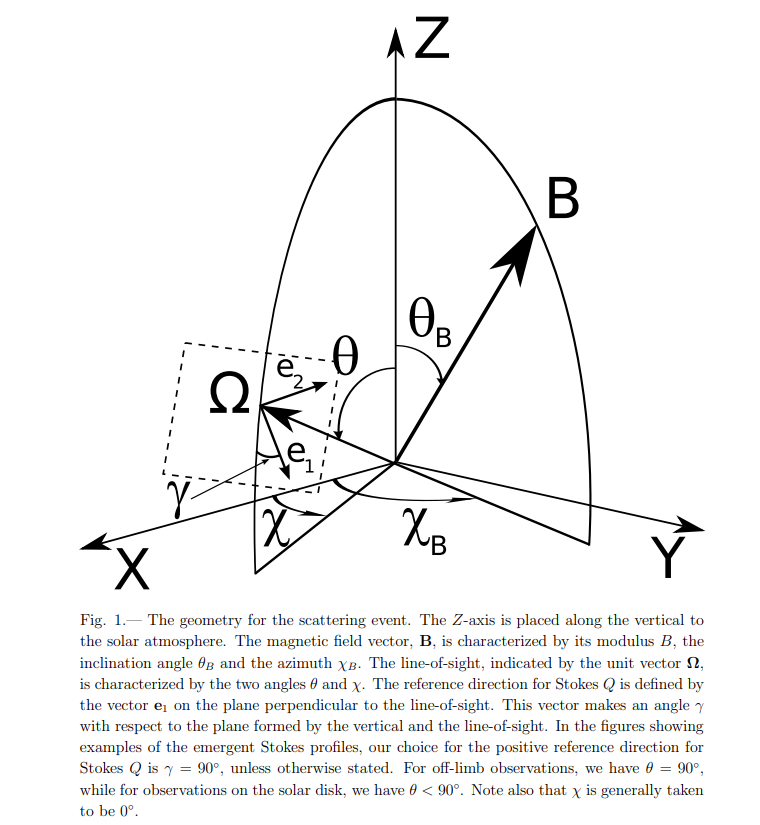

# Now we can try profile 6. This is a prominence, 22" above the limb!

# We can also try out spicule spectra (profiles 8 and 9).

In [12]:
data = np.loadtxt("profiles/profA8.perf",skiprows=1,unpack=True)
data.shape
ll = np.copy(data[0]) + 10829.09
stokes = np.copy(data[1:5])
noise = np.copy(data[5:])

In [13]:
data_prom = np.loadtxt("profiles/profA6.perf",skiprows=1,unpack=True)
data_prom.shape
ll_prom = np.copy(data_prom[0]) + 10829.09
stokes_prom = np.copy(data_prom[1:5])
noise_prom = np.copy(data_prom[5:])

Text(0.5, 0, 'Wavelength')

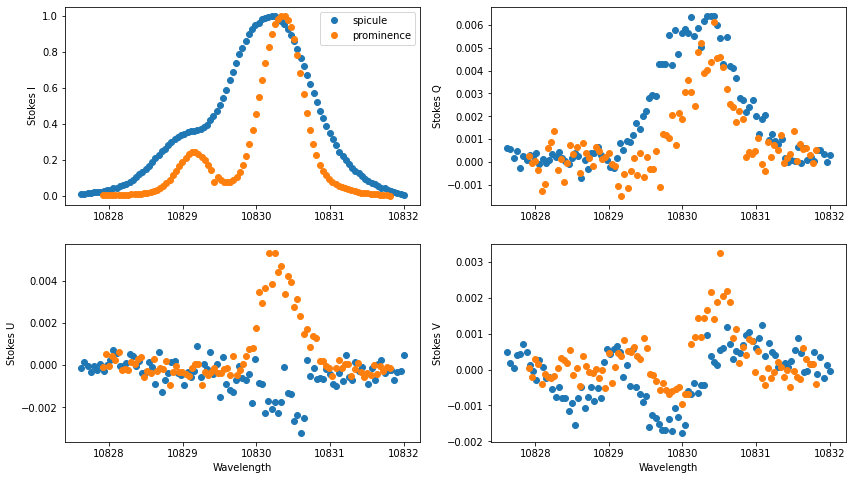

In [16]:
plt.figure(figsize=[14,8])
plt.subplot(221)
plt.plot(ll,stokes[0,:],'o',label='spicule')
plt.plot(ll_prom,stokes_prom[0,:],'o',label='prominence')
plt.legend()
plt.ylabel("Stokes I")
plt.subplot(222)
plt.plot(ll,stokes[1,:],'o')
plt.plot(ll_prom,stokes_prom[1,:],'o')
plt.ylabel("Stokes Q")
plt.subplot(223)
plt.plot(ll,stokes[2,:],'o')
plt.plot(ll_prom,stokes_prom[2,:],'o')
plt.ylabel("Stokes U")
plt.xlabel("Wavelength")
plt.subplot(224)
plt.plot(ll,stokes[3,:],'o')
plt.plot(ll_prom,stokes_prom[3,:],'o')
plt.ylabel("Stokes V")
plt.xlabel("Wavelength")

In [18]:
# First the wavelength axis
n_wvl = len(ll)
np.savetxt('10830_A8.wavelength', ll, header='lambda')

# Then we will save something called, 'weigths', this will allow us to fine-tune the inversion if needed.
f = open('10830_A8.weights', 'w')
f.write('# WeightI WeightQ WeightU WeightV\n')
for i in range(n_wvl):
    f.write('1.0    1.0   1.0   1.0\n')
f.close()

stokes_to_fit = stokes

# And finally, the 'observed' Stokes parameters:

f = open('10830_A8_stokes.1d', 'wb')
f.write(b'# LOS theta_LOS, phi_LOS, gamma_LOS\n')
f.write(b'90.0 0.0 90.0\n') # This should be identical to the above otherwise we will get inconsistent results. 
                            # this is something you should know from the observations
f.write(b'\n')
f.write(b'# Boundary condition I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)\n')
f.write(b'0.0 0.0 0.0 0.0\n')
f.write(b'\n')
f.write(b'# SI SQ SU SV sigmaI sigmaQ sigmaU sigmaV\n')
tmp = np.vstack([stokes_to_fit, noise]) # the second one only adds appropriate noise next to each Stokes
                                                        # measurement
np.savetxt(f, tmp.T)
f.close()


In [35]:
iterator = hazel.Iterator(use_mpi=False)
mod = hazel.Model('conf_test_A8.ini', working_mode='inversion', verbose=1, rank=iterator.get_rank(), randomization=20)
iterator.use_model(model=mod)
iterator.run_all_pixels()

2022-02-04 12:01:36,231 - Hazel2 v1.0
2022-02-04 12:01:36,232 - Using configuration from file : conf_test_A8.ini
2022-02-04 12:01:36,233 - Backtracking mode : brent
2022-02-04 12:01:36,234 - Adding spectral region spec1
2022-02-04 12:01:36,234 -   - Reading wavelength axis from 10830_A8.wavelength
2022-02-04 12:01:36,235 -   - Reading wavelength weights from 10830_A8.weights
2022-02-04 12:01:36,236 -   - Using observations from 10830_A8_stokes.1d
2022-02-04 12:01:36,237 -   - No mask for pixels
2022-02-04 12:01:36,237 -   - No instrumental profile
2022-02-04 12:01:36,237 -   - Using LOS ['90.0', '0.0', '90.0']
2022-02-04 12:01:36,238 -   - Using off-limb normalization (peak intensity)
2022-02-04 12:01:36,238 -   - Using boundary condition ['0.0', '0.0', '0.0', '0.0']
2022-02-04 12:01:36,238 - Using 2 cycles
2022-02-04 12:01:36,239 - Using analytical RFs if possible : False
2022-02-04 12:01:36,239 - Using 20 max. iterations
2022-02-04 12:01:36,239 - Using a maximum of 20 randomizations


In [36]:
result = h5py.File('output_onepixel.h5','r')
fit = np.copy(result['spec1']['stokes'])
fit = fit.reshape(20,4,n_wvl)
fit.shape

(20, 4, 101)

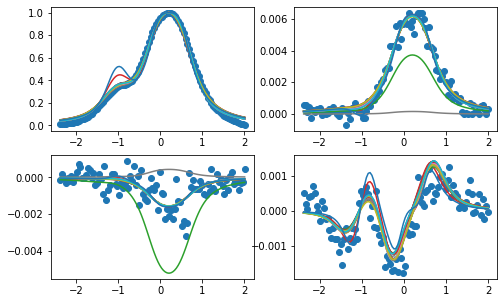

In [37]:
plt.figure(figsize=[8,5])
r = 0
plt.subplot(221)
plt.plot(ll-10830,stokes_to_fit[0,:],'o')
for r in range(0,20):
    plt.plot(ll-10830,fit[r,0,:])
plt.subplot(222)
plt.plot(ll-10830,stokes_to_fit[1,:],'o')
for r in range(0,20):
    plt.plot(ll-10830,fit[r,1,:])
plt.subplot(223)
plt.plot(ll-10830,stokes_to_fit[2,:],'o')
for r in range(0,20):
    plt.plot(ll-10830,fit[r,2,:])
plt.subplot(224)
plt.plot(ll-10830,stokes_to_fit[3,:],'o')
for r in range(0,20):
    plt.plot(ll-10830,fit[r,3,:])

In [39]:
print (result['spec1']['chi2'][0,:,1])

[0.2683943  0.2689849  0.29009821 0.29769255 0.30144233 0.26367762
 2.33084569 0.26367532 0.26446768 0.30196561 0.29724615 1.27216092
 0.30500624 0.29558142 0.29722543 0.26465554 0.27110073 0.27042618
 0.29561296 0.35560784]


In [41]:
good = np.array([0,1,2,3,4,5,7,8,9,10,12,13,14,15,16,17,18,19])

In [43]:
result['ch1']['Bx'].shape

(1, 20, 1)

[19.03310402 19.15889333 15.88068666 18.38425162 18.46489711 18.46935335
 18.47493808 18.82640137 18.86272371 18.32729673 18.78114026 17.8012615
 18.32187802 18.8725405  19.26718681 19.63740972 17.8115876  12.08990244]
[  3.67108764  -3.68836316   3.21721536  14.77790366  14.84735165
  -3.5806329   -3.58131092   3.63464227  15.18183862 -14.7152834
  15.19926461 -14.17518595  14.70683455  -3.64153643  -3.7067209
   3.75933223 -14.18345119   9.53406664]
[ 21.78210453 -21.85453567  18.01085979  -2.1855971   -2.19723494
 -20.9885027  -20.99713844  21.44229817  -2.24005712   2.17774356
  -2.24184227   2.11058494  -2.17689531 -21.50111369 -22.00673281
  22.38876942   2.11146184  -1.5357909 ]


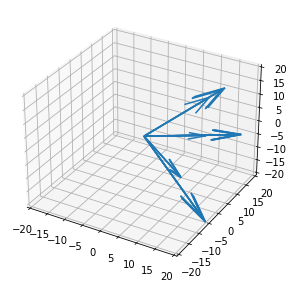

In [55]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

Bx = result['ch1']['Bx'][0,good,0]
By = result['ch1']['By'][0,good,0]
Bz = result['ch1']['Bz'][0,good,0]
print (Bx)
print (By)
print (Bz)

vectors = np.zeros([len(good),6])
for i in range(0,len(good)):
    #vectors[i] = np.array([[0, 0, 0, params_original[0],params_original[1],params_original[2]], [0, 0, 0, Bx,By,Bz]])
    vectors[i] = [0,0,0,Bx[i],By[i],Bz[i]]

X, Y, Z, U, V, W = zip(*vectors)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X, Y, Z, U, V, W)
ax.set_xlim([-20, 20])
ax.set_ylim([-20, 20])
ax.set_zlim([-20, 20])
plt.show()

## Let's plot these vectors in the plane of the sky! 

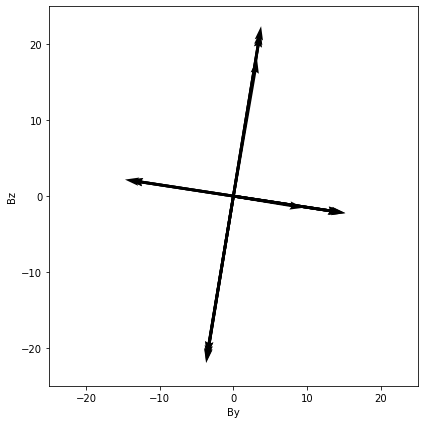

In [58]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [6, 6]
plt.rcParams["figure.autolayout"] = True

vectors2d = np.zeros([len(good),4])
for i in range(0,len(good)):
    vectors2d[i] = [0,0,By[i],Bz[i]]

X, Y, U, V = zip(*vectors2d)
plt.figure()
ax = plt.gca()
ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1)
ax.set_xlim([-25, 25])
ax.set_ylim([-25, 25])
plt.xlabel("By")
plt.ylabel("Bz")
plt.draw()
plt.show()

In [33]:
result['ch1'].keys()
# Print them neatly:
print ("Bx= ",result['ch1']['Bx'][0,0,0])
print ("By= ",result['ch1']['By'][0,0,0])
print ("Bz= ",result['ch1']['Bz'][0,0,0])
print ("tau= ",result['ch1']['tau'][0,0,0])
print ("vlos ",result['ch1']['v'][0,0,0])
print ("vtherm= ",result['ch1']['deltav'][0,0,0])
print ("a= ",result['ch1']['a'][0,0,0])
result.close()

ValueError: Invalid location identifier (invalid location identifier)

In [34]:
%rm output_onepixel.h5

## "And you're always going to come back to this picture...." How is the magnetic field looking like? 

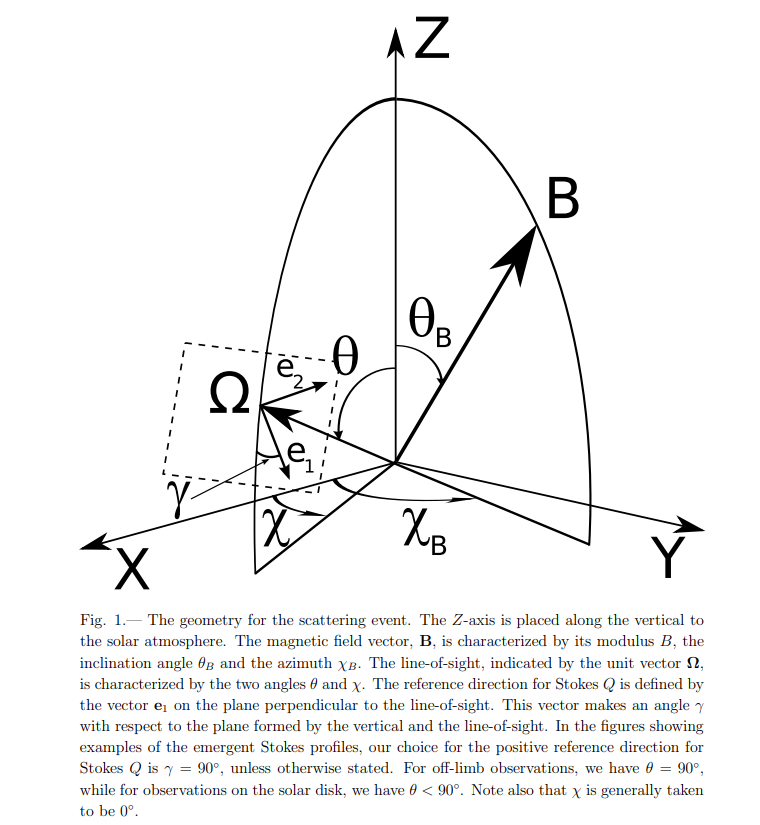